# Root Cause Analysis - PyRCA

## Import all the necessary libraries

In [64]:
import networkx as nx
import numpy as np
import pyrca

from pyrca.analyzers.ht import HT, HTConfig
from pyrca.analyzers.epsilon_diagnosis import EpsilonDiagnosis
from pyrca.analyzers.bayesian import BayesianNetwork

import matplotlib.pyplot as plt
import pandas as pd
import os


## Custom Functions

In [65]:
def draw_save(G,pos,node_color,file_name:str, inter_type:str):
    # Draw the graph
    plt.figure(figsize=(12, 10))
    plt.xlim((-12,14))
    plt.ylim((-10,8))
    plt.title(f'Causal Graph: {inter_type}', fontsize=15)
    nx.draw(G, pos,with_labels=True,node_size=2000, node_color=[new_colors[node] for node in G.nodes()], font_size=8, arrowsize=10,width=0.5)
    plt.savefig(file_name)

def get_file_name(var:str):
    return var[7:-4]

## Create the Causal Graph (non-lagged)

In [66]:
G = nx.DiGraph()
nodes = [
    'cam_1_X', 'cam_2_X', 'cam_3_X',
    'cam_1_Y', 'cam_2_Y', 'cam_3_Y',
    'EoL_1_X', 'EoL_2_X', 'EoL_3_X', 'EoL_4_X', 'EoL_5_X', 'EoL_6_X',
    'EoL_1_Y', 'EoL_2_Y', 'EoL_3_Y', 'EoL_4_Y', 'EoL_5_Y', 'EoL_6_Y',
    'rob_1_1', 'rob_1_2', 'rob_1_3', 'rob_1_4', 'rob_1_maxVel',
    'rob_2_1', 'rob_2_2', 'rob_2_3', 'rob_2_4', 'rob_2_maxVel',
    'rob_1_gripper', 'rob_2_gripper',
    'con_1','con_2','con_3'
]

edges = [
    ('cam_1_X', 'rob_2_1'), ('cam_1_Y', 'rob_2_1'),
    ('cam_1_X', 'rob_2_2'), ('cam_1_Y', 'rob_2_2'),
    ('cam_1_X', 'rob_2_3'), ('cam_1_Y', 'rob_2_3'),
    ('cam_1_X', 'rob_2_4'), ('cam_1_Y', 'rob_2_4'),
    
    ('cam_2_X', 'rob_1_1'), ('cam_2_Y', 'rob_1_1'),
    ('cam_2_X', 'rob_1_2'), ('cam_2_Y', 'rob_1_2'),
    ('cam_2_X', 'rob_1_3'), ('cam_2_Y', 'rob_1_3'),
    ('cam_2_X', 'rob_1_4'), ('cam_2_Y', 'rob_1_4'),
    
    ('cam_3_X', 'rob_1_1'), ('cam_3_Y', 'rob_1_1'),
    ('cam_3_X', 'rob_1_2'), ('cam_3_Y', 'rob_1_2'),
    ('cam_3_X', 'rob_1_3'), ('cam_3_Y', 'rob_1_3'),
    ('cam_3_X', 'rob_1_4'), ('cam_3_Y', 'rob_1_4'),
    
    ('rob_1_maxVel', 'rob_1_1'), ('rob_1_maxVel', 'rob_1_2'),
    ('rob_1_maxVel', 'rob_1_3'), ('rob_1_maxVel', 'rob_1_4'),
    
    ('rob_2_maxVel', 'rob_2_1'), ('rob_2_maxVel', 'rob_2_2'),
    ('rob_2_maxVel', 'rob_2_3'), ('rob_2_maxVel', 'rob_2_4'),
    
    ('con_2', 'rob_1_1'), ('con_2', 'rob_1_2'), ('con_2', 'rob_1_3'), ('con_2', 'rob_1_4'),
    ('con_3', 'rob_1_1'), ('con_3', 'rob_1_2'), ('con_3', 'rob_1_3'), ('con_3', 'rob_1_4'),

    ('con_2', 'rob_2_1'), ('con_2', 'rob_2_2'), ('con_2', 'rob_2_3'), ('con_2', 'rob_2_4'),
    ('con_1', 'rob_2_1'), ('con_1', 'rob_2_2'), ('con_1', 'rob_2_3'), ('con_1', 'rob_2_4'),

    ('con_2', 'EoL_1_X'), ('con_2', 'EoL_1_Y'),
    
    ('rob_1_1', 'rob_2_1'), ('rob_1_1', 'rob_2_2'), ('rob_1_1', 'rob_2_3'), ('rob_1_1', 'rob_2_4'),
    ('rob_1_2', 'rob_2_1'), ('rob_1_2', 'rob_2_2'), ('rob_1_2', 'rob_2_3'), ('rob_1_2', 'rob_2_4'),
    ('rob_1_3', 'rob_2_1'), ('rob_1_3', 'rob_2_2'), ('rob_1_3', 'rob_2_3'), ('rob_1_3', 'rob_2_4'),
    ('rob_1_4', 'rob_2_1'), ('rob_1_4', 'rob_2_2'), ('rob_1_4', 'rob_2_3'), ('rob_1_4', 'rob_2_4'),
    
    ('rob_1_gripper', 'rob_2_1'), ('rob_1_gripper', 'rob_2_2'),
    ('rob_1_gripper', 'rob_2_3'), ('rob_1_gripper', 'rob_2_4'),

    ('rob_1_1', 'EoL_2_X'), ('rob_1_2', 'EoL_2_X'),
    ('rob_1_3', 'EoL_2_X'), ('rob_1_4', 'EoL_2_X'),
    ('rob_1_1', 'EoL_2_Y'), ('rob_1_2', 'EoL_2_Y'),
    ('rob_1_3', 'EoL_2_Y'), ('rob_1_4', 'EoL_2_Y'),
    
    ('rob_2_1', 'EoL_3_X'), ('rob_2_2', 'EoL_3_X'),
    ('rob_2_3', 'EoL_3_X'), ('rob_2_4', 'EoL_3_X'),
    ('rob_2_1', 'EoL_3_Y'), ('rob_2_2', 'EoL_3_Y'),
    ('rob_2_3', 'EoL_3_Y'), ('rob_2_4', 'EoL_3_Y'),
    
    ('rob_2_1', 'EoL_4_X'), ('rob_2_2', 'EoL_4_X'),
    ('rob_2_3', 'EoL_4_X'), ('rob_2_4', 'EoL_4_X'),
    ('rob_2_1', 'EoL_4_Y'), ('rob_2_2', 'EoL_4_Y'),
    ('rob_2_3', 'EoL_4_Y'), ('rob_2_4', 'EoL_4_Y'),
    
    ('rob_2_1', 'EoL_5_X'), ('rob_2_2', 'EoL_5_X'),
    ('rob_2_3', 'EoL_5_X'), ('rob_2_4', 'EoL_5_X'),
    ('rob_2_1', 'EoL_5_Y'), ('rob_2_2', 'EoL_5_Y'),
    ('rob_2_3', 'EoL_5_Y'), ('rob_2_4', 'EoL_5_Y'),

    ('rob_2_1', 'EoL_6_X'), ('rob_2_2', 'EoL_6_X'),
    ('rob_2_3', 'EoL_6_X'), ('rob_2_4', 'EoL_6_X'),
    ('rob_2_1', 'EoL_6_Y'), ('rob_2_2', 'EoL_6_Y'),
    ('rob_2_3', 'EoL_6_Y'), ('rob_2_4', 'EoL_6_Y'),

    ('rob_1_gripper', 'EoL_2_X'), ('rob_1_gripper', 'EoL_2_Y'),
    
    ('rob_2_gripper', 'EoL_3_X'), ('rob_2_gripper', 'EoL_3_Y'),
    ('rob_2_gripper', 'EoL_4_X'), ('rob_2_gripper', 'EoL_4_Y'),
    ('rob_2_gripper', 'EoL_5_X'), ('rob_2_gripper', 'EoL_5_Y'),
    ('rob_2_gripper', 'EoL_6_X'), ('rob_2_gripper', 'EoL_6_Y'),
]

EoL_nodes = [
    'EoL_1_X', 'EoL_2_X', 'EoL_3_X', 'EoL_4_X', 'EoL_5_X', 'EoL_6_X',
    'EoL_1_Y', 'EoL_2_Y', 'EoL_3_Y', 'EoL_4_Y', 'EoL_5_Y', 'EoL_6_Y'
]

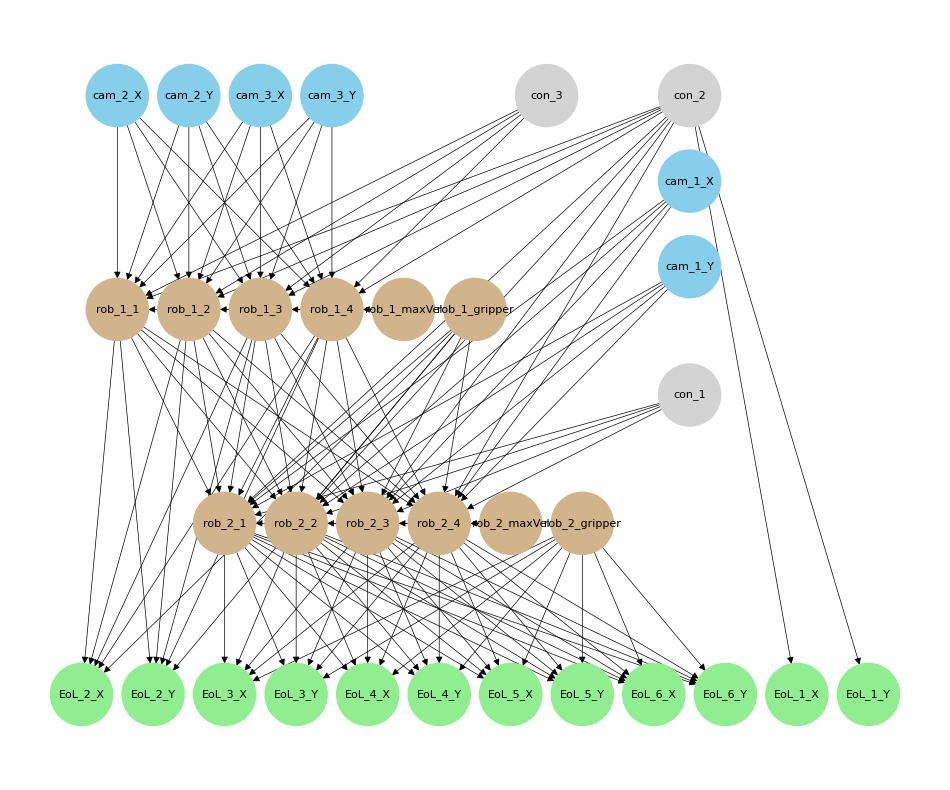

In [67]:
G.add_nodes_from(nodes)

G.add_edges_from(edges)

pos = {
    'cam_1_X':(7,4), 'cam_2_X':(-9,6), 'cam_3_X':(-5,6),
    'cam_1_Y':(7,2), 'cam_2_Y':(-7,6), 'cam_3_Y':(-3,6),
    'EoL_1_X':(10,-8), 'EoL_2_X':(-10,-8), 'EoL_3_X':(-6,-8), 'EoL_4_X':(-2,-8), 'EoL_5_X':(2,-8), 'EoL_6_X':(6,-8),
    'EoL_1_Y':(12,-8), 'EoL_2_Y':(-8,-8), 'EoL_3_Y':(-4,-8), 'EoL_4_Y':(0,-8), 'EoL_5_Y':(4,-8), 'EoL_6_Y':(8,-8),
    'rob_2_1':(-6,-4), 'rob_2_2':(-4,-4), 'rob_2_3':(-2,-4), 'rob_2_4':(-0,-4), 'rob_2_maxVel':(2,-4),
    'rob_1_1':(-9,1), 'rob_1_2':(-7,1), 'rob_1_3':(-5,1), 'rob_1_4':(-3,1), 'rob_1_maxVel':(-1,1),
    'rob_1_gripper':(1,1), 'rob_2_gripper':(4,-4),
    'con_1':(7,-1),'con_2':(7,6),'con_3':(3,6)
}

colors = {
    'cam_1_X':'skyblue', 'cam_2_X':'skyblue', 'cam_3_X':'skyblue',
    'cam_1_Y':'skyblue', 'cam_2_Y':'skyblue', 'cam_3_Y':'skyblue',
    'EoL_1_X':'lightgreen', 'EoL_2_X':'lightgreen', 'EoL_3_X':'lightgreen', 'EoL_4_X':'lightgreen', 'EoL_5_X':'lightgreen', 'EoL_6_X':'lightgreen',
    'EoL_1_Y':'lightgreen', 'EoL_2_Y':'lightgreen', 'EoL_3_Y':'lightgreen', 'EoL_4_Y':'lightgreen', 'EoL_5_Y':'lightgreen', 'EoL_6_Y':'lightgreen',
    'rob_1_1':'tan', 'rob_1_2':'tan', 'rob_1_3':'tan', 'rob_1_4':'tan', 'rob_1_maxVel':'tan',
    'rob_2_1':'tan', 'rob_2_2':'tan', 'rob_2_3':'tan', 'rob_2_4':'tan', 'rob_2_maxVel':'tan',
    'rob_1_gripper':'tan', 'rob_2_gripper':'tan',
    'con_1':'lightgrey','con_2':'lightgrey','con_3':'lightgrey'
}

# Draw the graph
plt.figure(figsize=(12, 10))
plt.xlim((-12,14))
plt.ylim((-10,8))
nx.draw(G, pos,with_labels=True,node_size=2000, node_color=[colors[node] for node in G.nodes()], font_size=8, arrowsize=10,width=0.5)

### Retrieve the adjacency matrix from the causal graph

In [68]:
adj_matrix_extended_pd = nx.to_pandas_adjacency(G,nodes)

adj_matrix_extended = nx.adjacency_matrix(G,nodes).todense()
adjacency_df = pd.DataFrame(adj_matrix_extended, index=G.nodes(), columns=G.nodes())

##Show datasets in folders

In [69]:
# Specify the directory path
directory_path = 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset'

# Get a list of all items (files and directories) in the specified path
all_items = os.listdir(directory_path)

# Iterate over each item and check if it's a directory
for item in all_items:
    folder_path = os.path.join(directory_path, item)
    if os.path.isdir(folder_path):
        print(f"Processing folder: {item}")

        folder_contents = os.listdir(folder_path)
        for file in folder_contents:
            file_path = os.path.join(folder_path, file)
            print(f"-> {file}")

Processing folder: Dataset_2024-06-18_18-29-49
-> data_1_normal.csv
-> data_2_gripper_1.csv
-> data_3_gripper_2.csv
-> true_no_lagged_graph_extendend.csv
Processing folder: Dataset_2024-06-20_11-03-11
-> data_1_normal.csv
-> data_2_gripper_1.csv
-> data_3_gripper_2.csv
-> true_no_lagged_graph_extendend.csv
Processing folder: Dataset_2024-06-20_12-17-42
-> data_1_normal.csv
-> data_2_gripper_1.csv
-> data_3_gripper_2.csv
-> true_no_lagged_graph_extendend.csv
Processing folder: Dataset_2024-06-20_12-40-28
-> data_1_normal.csv
-> data_2_gripper_1.csv
-> data_3_gripper_2.csv
-> true_no_lagged_graph_extendend.csv
Processing folder: Dataset_2024-06-20_16-26-23
-> data_1_normal.csv
-> data_2_gripper_1.csv
-> data_3_gripper_2.csv
-> true_no_lagged_graph_extendend.csv
-> data_4_camera_1.csv


## Select folder to read

In [70]:
# Specify the directory path
directory_path = 'G:\\My Drive\\Master Thesis\\Simulation\\Dataset'
files = {}
folder = 'Dataset_2024-06-20_16-26-23'

folder_path = os.path.join(directory_path, folder)
if os.path.isdir(folder_path):
    print(f"Processing folder: {item}")
    folder_contents = os.listdir(folder_path)
    for file in folder_contents:
        file_path = os.path.join(folder_path, file)
        print(f"-> {file}")
        if file[0:4] == 'data':
             files[f"{get_file_name(file)}"] = file_path

Processing folder: Dataset_2024-06-20_16-26-23
-> data_1_normal.csv
-> data_2_gripper_1.csv
-> data_3_gripper_2.csv
-> true_no_lagged_graph_extendend.csv
-> data_4_camera_1.csv


## Run RCA trough folder

In [76]:
for file in files:
    if file == 'normal':
        load_normal(files[file])

G:\My Drive\Master Thesis\Simulation\Dataset\Dataset_2024-06-20_16-26-23\data_1_normal.csv


## Root cause analysis

### Load Normal dataset

In [ ]:
normal_data_df = pd.read_csv(files['Dataset_2024-06-20_16-26-23_data_1_normal.csv'],skiprows=range(1, 1000))
normal_data_df = normal_data_df[nodes]
normal_data_df.head()

### Load Abnormal datasets

In [ ]:
abnormal_data_df_1 = pd.read_csv(files['Dataset_2024-06-20_16-26-23_data_2_gripper_1.csv'],skiprows=range(1, 1000)) #nrows=1
abnormal_data_df_1 = abnormal_data_df_1[nodes]
#abnormal_data_df_1.head()

In [ ]:
abnormal_data_df_2 = pd.read_csv(files['Dataset_2024-06-20_16-26-23_data_3_gripper_2.csv'],skiprows=range(1, 1000)) #nrows=1
abnormal_data_df_2 = abnormal_data_df_2[nodes]
#abnormal_data_df_2.head()

In [ ]:
abnormal_data_df_3 = pd.read_csv(files['Dataset_2024-06-20_20-23-10_data_4_camera_1.csv'],skiprows=range(1, 1000)) #nrows=1
abnormal_data_df_3 = abnormal_data_df_3[nodes]
#abnormal_data_df_3.head()

In [ ]:
abnormal_data_df_4 = pd.read_csv(files['Dataset_2024-06-20_20-23-10_data_5_conveyor_1.csv'],skiprows=range(1, 1000)) #nrows=1
abnormal_data_df_4 = abnormal_data_df_4[nodes]
abnormal_data_df_4.head()

### Combine datasets into one set for training

In [ ]:
data_df = pd.concat([normal_data_df,abnormal_data_df_1.loc[abnormal_data_df_1.index]],ignore_index=True)
data_df = pd.concat([data_df,abnormal_data_df_2.loc[abnormal_data_df_2.index]],ignore_index=True)
data_df = pd.concat([data_df,abnormal_data_df_3.loc[abnormal_data_df_3.index]],ignore_index=True)
data_df = pd.concat([data_df,abnormal_data_df_4.loc[abnormal_data_df_4.index]],ignore_index=True)
data_df.head()

### Cardinality test of dataset

In [ ]:
cardinality_nodes = list()
# Check all data entries for uniqueness (cardinality)
for node in nodes:
    unique_values = data_df[node].unique()
    cardinality = len(unique_values)
    if cardinality == 1:
        cardinality_nodes.append(node)
print(f"We need to remove {cardinality_nodes}.")

### Algorithm #1: Hypothesis Testing

#### Model Training

In [ ]:
model = HT(config=HTConfig(adj_matrix_extended_pd))

model.train(normal_data_df)

#### Intervention: Gripper 1

In [ ]:
abnormal_nodes = []
new_colors = colors.copy()

results = pd.DataFrame()
for node in EoL_nodes:
    # Basic Anomaly Detection
    if (abnormal_data_df_1[node] == 0.0).any():
        abnormal_nodes.append(node)
        new_colors[node] = 'yellow'
        results[node] = model.find_root_causes(abnormal_data_df_1,node, True).to_list()

rank1_root_cause = list()
rank2_root_cause = list()
rank3_root_cause = list()

for node in abnormal_nodes:
    rank1_root_cause.append(results[node][0]['root_cause'])
    rank2_root_cause.append(results[node][1]['root_cause'])
    rank3_root_cause.append(results[node][2]['root_cause'])

for node in rank1_root_cause:
     new_colors[node] = 'red'

for node in rank2_root_cause:
     new_colors[node] = 'crimson'

for node in rank3_root_cause:
     new_colors[node] = 'lightcoral'

draw_save(G,pos,new_colors,file_name='causal_graph_gripper_1_HT.png', inter_type= 'Intervention Gripper 1')


#### Intervention: Gripper 2

In [ ]:
abnormal_nodes = []
new_colors = colors.copy()

results = pd.DataFrame()
for node in EoL_nodes:
    # Basic Anomaly Detection
    if (abnormal_data_df_2[node] == 0.0).any():
        abnormal_nodes.append(node)
        new_colors[node] = 'yellow'
        results[node] = model.find_root_causes(abnormal_data_df_2,node, True).to_list()
        test = results

rank1_root_cause = list()
rank2_root_cause = list()
rank3_root_cause = list()

for node in abnormal_nodes:
    rank1_root_cause.append(results[node][0]['root_cause'])
    rank2_root_cause.append(results[node][1]['root_cause'])
    rank3_root_cause.append(results[node][2]['root_cause'])

for node in rank1_root_cause:
     new_colors[node] = 'red'

for node in rank2_root_cause:
     new_colors[node] = 'crimson'

for node in rank3_root_cause:
     new_colors[node] = 'indianred'
     
draw_save(G,pos,new_colors,file_name='causal_graph_gripper_2_HT.png', inter_type= 'Intervention Gripper 2')

#### Intervention: Camera 1

In [ ]:
abnormal_nodes = []
new_colors = colors.copy()

results = pd.DataFrame()
for node in EoL_nodes:
    # Basic Anomaly Detection
    if (abnormal_data_df_3[node] == 0.0).any():
        abnormal_nodes.append(node)
        new_colors[node] = 'yellow'
        results[node] = model.find_root_causes(abnormal_data_df_3,node, True).to_list()
        test = results

rank1_root_cause = list()
rank2_root_cause = list()
rank3_root_cause = list()

for node in abnormal_nodes:
    rank1_root_cause.append(results[node][0]['root_cause'])
    rank2_root_cause.append(results[node][1]['root_cause'])
    rank3_root_cause.append(results[node][2]['root_cause'])

for node in rank1_root_cause:
     new_colors[node] = 'red'

for node in rank2_root_cause:
     new_colors[node] = 'crimson'

for node in rank3_root_cause:
     new_colors[node] = 'indianred'


draw_save(G,pos,new_colors,file_name='causal_graph_camera_1_HT.png', inter_type= 'Intervention Camera 1')

#### Intervention: Conveyor 1

In [ ]:
abnormal_nodes = []
new_colors = colors.copy()

results = pd.DataFrame()
for node in EoL_nodes:
    # Basic Anomaly Detection
    if (abnormal_data_df_4[node] == 0.0).any():
        abnormal_nodes.append(node)
        new_colors[node] = 'yellow'
        results[node] = model.find_root_causes(abnormal_data_df_4,node, True).to_list()
        test = results

rank1_root_cause = list()
rank2_root_cause = list()
rank3_root_cause = list()

for node in abnormal_nodes:
    rank1_root_cause.append(results[node][0]['root_cause'])
    rank2_root_cause.append(results[node][1]['root_cause'])
    rank3_root_cause.append(results[node][2]['root_cause'])

for node in rank1_root_cause:
     new_colors[node] = 'red'

for node in rank2_root_cause:
     new_colors[node] = 'crimson'

for node in rank3_root_cause:
     new_colors[node] = 'indianred'

# Draw the graph
plt.figure(figsize=(12, 10))
plt.xlim((-12,14))
plt.ylim((-10,8))
plt.title('Causal Graph: Intervention Conveyor 1', fontsize=15)
nx.draw(G, pos,with_labels=True,node_size=2000, node_color=[new_colors[node] for node in G.nodes()], font_size=8, arrowsize=10,width=0.5)
plt.savefig('causal_graph_conveyor_1_HT.png')

### Algorithm #2: Epsilon Diagnosis

#### Model Training

In [ ]:
model = EpsilonDiagnosis(config=EpsilonDiagnosis.config_class(alpha=0.5))
model.train(normal_data_df)

#### Intervention: Gripper 1

In [ ]:
abnormal_nodes = []
new_colors = colors.copy()

for node in EoL_nodes:
    # Basic Anomaly Detection
    if (abnormal_data_df_1[node] == 0.0).any():
        abnormal_nodes.append(node)
        new_colors[node] = 'yellow'

results = model.find_root_causes(abnormal_data_df_1)
root_cause_nodes = pd.DataFrame(results.root_cause_nodes)

new_colors[root_cause_nodes[0][0]] = 'red'

new_colors[root_cause_nodes[0][1]] = 'crimson'

new_colors[root_cause_nodes[0][2]] = 'indianred'

# Draw the graph
plt.figure(figsize=(12, 10))
plt.xlim((-12,14))
plt.ylim((-10,8))
plt.title('Causal Graph: Intervention Gripper 1', fontsize=15)
nx.draw(G, pos,with_labels=True,node_size=2000, node_color=[new_colors[node] for node in G.nodes()], font_size=8, arrowsize=10,width=0.5)
plt.savefig('causal_graph_gripper_1_ED.png')


#### Intervention: Gripper 2

In [ ]:
abnormal_nodes = []
new_colors = colors.copy()

for node in EoL_nodes:
    # Basic Anomaly Detection
    if (abnormal_data_df_2[node] == 0.0).any():
        abnormal_nodes.append(node)
        new_colors[node] = 'yellow'

results = model.find_root_causes(abnormal_data_df_2)
root_cause_nodes = pd.DataFrame(results.root_cause_nodes)

new_colors[root_cause_nodes[0][0]] = 'red'

new_colors[root_cause_nodes[0][1]] = 'crimson'

new_colors[root_cause_nodes[0][2]] = 'indianred'

# Draw the graph
plt.figure(figsize=(12, 10))
plt.xlim((-12,14))
plt.ylim((-10,8))
plt.title('Causal Graph: Intervention Gripper 2', fontsize=15)
nx.draw(G, pos,with_labels=True,node_size=2000, node_color=[new_colors[node] for node in G.nodes()], font_size=8, arrowsize=10,width=0.5)
plt.savefig('causal_graph_gripper_2_ED.png')

#### Intervention: Camera 1

In [ ]:
abnormal_nodes = []
new_colors = colors.copy()

for node in EoL_nodes:
    # Basic Anomaly Detection
    if (abnormal_data_df_3[node] == 0.0).any():
        abnormal_nodes.append(node)
        new_colors[node] = 'yellow'

results = model.find_root_causes(abnormal_data_df_3)
root_cause_nodes = pd.DataFrame(results.root_cause_nodes)

new_colors[root_cause_nodes[0][0]] = 'red'

new_colors[root_cause_nodes[0][1]] = 'crimson'

new_colors[root_cause_nodes[0][2]] = 'indianred'

# Draw the graph
plt.figure(figsize=(12, 10))
plt.xlim((-12,14))
plt.ylim((-10,8))
plt.title('Causal Graph: Intervention Camera 1', fontsize=15)
nx.draw(G, pos,with_labels=True,node_size=2000, node_color=[new_colors[node] for node in G.nodes()], font_size=8, arrowsize=10,width=0.5)
plt.savefig('causal_graph_gripper_3_ED.png')

### Algorithm #3: Bayesian Network

#### Model Training

The data for the bayesian network, needs to cover all instances of failure.

In [ ]:
model = BayesianNetwork(config=BayesianNetwork.config_class(adjacency_df))

trained_model = model.train(data_df)
#model.save("model_folder")

#### Intervention: Gripper 1

In [ ]:
abnormal_nodes = []
new_colors = colors.copy()

for node in EoL_nodes:
    # Basic Anomaly Detection
    if (abnormal_data_df[node] == 0.0).any():
        abnormal_nodes.append(node)
        new_colors[node] = 'yellow'

results = model.find_root_causes(abnormal_data_df)
root_cause_nodes = pd.DataFrame(results.root_cause_nodes)

for node in root_cause_nodes[0]:
     new_colors[node] = 'red'

# Draw the graph
plt.figure(figsize=(12, 10))
plt.xlim((-12,14))
plt.ylim((-10,8))
plt.title('Causal Graph: Intervention Gripper 1', fontsize=15)
nx.draw(G, pos,with_labels=True,node_size=2000, node_color=[new_colors[node] for node in G.nodes()], font_size=8, arrowsize=10,width=0.5)
plt.savefig('causal_graph_gripper_1_ED.png')


#### Intervention: Gripper 2

In [ ]:
abnormal_nodes = []
new_colors = colors.copy()

for node in EoL_nodes:
    # Basic Anomaly Detection
    if (abnormal_data_df[node] == 0.0).any():
        abnormal_nodes.append(node)
        new_colors[node] = 'yellow'

results = model.find_root_causes(abnormal_data_df)
root_cause_nodes = pd.DataFrame(results.root_cause_nodes)

for node in root_cause_nodes[0]:
     new_colors[node] = 'red'

# Draw the graph
plt.figure(figsize=(12, 10))
plt.xlim((-12,14))
plt.ylim((-10,8))
plt.title('Causal Graph: Intervention Gripper 2', fontsize=15)
nx.draw(G, pos,with_labels=True,node_size=2000, node_color=[new_colors[node] for node in G.nodes()], font_size=8, arrowsize=10,width=0.5)
plt.savefig('causal_graph_gripper_2_ED.png')

In [ ]:
abnormal_data_df = pd.read_csv(files['data_3_gripper_2.csv'],skiprows=range(1, 660))
abnormal_data_df = abnormal_data_df[nodes]
size = abnormal_data_df.shape
print(size)
abnormal_data_df.head()

In [ ]:
abnormal_nodes = []
new_colors = colors.copy()

for node in EoL_nodes:
    # Basic Anomaly Detection
    if (abnormal_data_df[node] == 0.0).any():
        abnormal_nodes.append(node)
        new_colors[node] = 'yellow'

results = model.find_root_causes(abnormal_data_df)
root_cause_nodes = pd.DataFrame(results.root_cause_nodes)

for node in root_cause_nodes[0]:
     new_colors[node] = 'red'

# Draw the graph
plt.figure(figsize=(12, 10))
plt.xlim((-12,14))
plt.ylim((-10,8))
plt.title('Causal Graph: Intervention Gripper 2', fontsize=15)
nx.draw(G, pos,with_labels=True,node_size=2000, node_color=[new_colors[node] for node in G.nodes()], font_size=8, arrowsize=10,width=0.5)
plt.savefig('causal_graph_gripper_2_ED.png')

In [ ]:
# You can put the code here to a file named test.py
from baro.anomaly_detection import bocpd
from baro.root_cause_analysis import robust_scorer
from baro.utility import download_data, read_data

# download a sample data to data.csv
download_data()

# read data from data.csv
data = read_data("data.csv")

# perform anomaly detection 
anomalies = bocpd(data) 
print("Anomalies are detected at timestep:", anomalies[0])

# perform root cause analysis
root_causes = robust_scorer(data, anomalies=anomalies)["ranks"]

# print the top 5 root causes
print("Top 5 root causes:", root_causes[:5])

In [ ]:
from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas
from causalnex.network import BayesianNetwork
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

# Create a StructureModel (initially empty)
sm = StructureModel()

# Add nodes
sm.add_nodes_from(['A', 'B', 'C'])

# Add edges (directed links)
sm.add_edge('A', 'B')
sm.add_edge('B', 'C')

# Visualize the structure (optional)
viz = plot_structure(sm, graph_attributes={'scale': '0.5'},
                     all_node_attributes=NODE_STYLE.WEAK,
                     all_edge_attributes=EDGE_STYLE.WEAK)
viz.draw('images/bn_graph.png')

# Create a Bayesian Network from the StructureModel
bn = BayesianNetwork(sm)

# Plot the Bayesian Network (DAG)
viz.draw()